In [1]:
import anfis
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

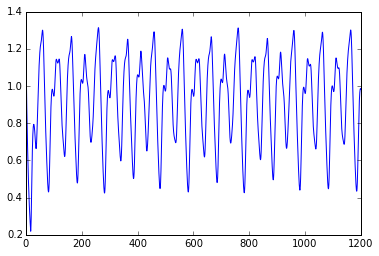

In [2]:
# Mackey-Glass time delay time differential equation
a        = 0.2      # value for a in eq (1)
b        = 0.1      # value for b in eq (1)
tau      = 17       # delay constant in eq (1)
x0       = 1.2      # initial condition: x(t=0)=x0
deltat   = 0.1      # time step size (which coincides with the integration step)
sample_n = 12000    # total no. of samples, excluding the given initial condition
interval = 1        # output is printed at every 'interval' time steps

time = 0
index = 1
history_length = int(np.floor(tau/deltat))
x_history = np.zeros(history_length) # here we assume x(t)=0 for -tau <= t < 0
x_t = x0

X = np.zeros(sample_n+1) # vector of all generated x samples
T = np.zeros(sample_n+1) # vector of time samples

def mackeyglass_eq(x_t, x_t_minus_tau, a, b):
    # print(a,b, x_t, x_t_minus_tau)
    x_dot = -b*x_t + a*x_t_minus_tau/(1 + x_t_minus_tau**10.0)
    return x_dot

def mackeyglass_rk4(x_t, x_t_minus_tau, deltat, a, b):
    k1 = deltat*mackeyglass_eq(x_t,          x_t_minus_tau, a, b)
    k2 = deltat*mackeyglass_eq(x_t+0.5*k1,   x_t_minus_tau, a, b)
    k3 = deltat*mackeyglass_eq(x_t+0.5*k2,   x_t_minus_tau, a, b)
    k4 = deltat*mackeyglass_eq(x_t+k3,       x_t_minus_tau, a, b)
    x_t_plus_deltat = (x_t + k1/6 + k2/3 + k3/3 + k4/6)
    return x_t_plus_deltat

for i in range(1,sample_n+1):
    X[i-1] = x_t;
    if (i-1 % interval == 0):
        print('%s %s' % ((i-1)/interval, x_t))
    if tau == 0:
        x_t_minus_tau = 0.0
    else:
        x_t_minus_tau = x_history[index-1]
    
    # print("x(t-tau): %s" % x_t_minus_tau)
    x_t_plus_deltat = mackeyglass_rk4(x_t, x_t_minus_tau, deltat, a, b)
    # print("x(t + delta_t): %s" % x_t_plus_deltat)
    
    if (tau != 0):
        x_history[index-1] = x_t_plus_deltat
        index = index % history_length +1
        
    time = time + deltat
    T[i] = time
    x_t = x_t_plus_deltat

T = T[:-1]
X = X[:-1]
plt.figure()
plt.plot(T, X)
#plt.set_xlim(0, T(end))

In [3]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def embedding_reconstruction(signal_arr, delay, dim):
    d = dim - 1
    tau = delay
    rolling_win = tau * d + 1
    
    sample = np.array([x[::tau] for x in rolling_window(signal_arr,rolling_win)])
    return sample

def make_sym_dist_matrix(arr_of_points):
    from scipy.spatial.distance import pdist
    vals = pdist(arr_of_points, 'euclidean')
    n = len(arr_of_points)
    m = np.zeros([n,n], dtype=np.double)
    xs,ys = np.triu_indices(n,k=1)
    m[xs,ys] = vals
    m[ys,xs] = vals
    m[np.diag_indices(n)] = 0
    return m

A = np.array(range(0,26))
B = rolling_window(A,25)
B[0][::6]

array([ 0,  6, 12, 18, 24])

In [4]:
sample = embedding_reconstruction(X, delay=6, dim=5)
train_vect = sample[:,0:3]
output_vect = sample[:,-1]


In [5]:
sample_size = len(output_vect)
train_size = int(sample_size/2)

train_X = train_vect[:train_size,]
test_X = train_vect[train_size+1:,]

train_Y = output_vect[:train_size]
test_Y = output_vect[train_size+1:]

from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(train_X, train_Y).predict(train_X)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid)
grid.fit(train_X, train_Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The best parameters are {'C': 1000000.0, 'gamma': 1.0000000000000001e-05} with a score of 0.93


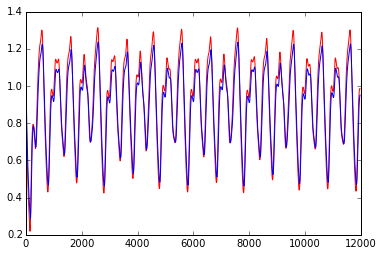

In [7]:
y_rbf = grid.predict(train_vect)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


plt.plot(output_vect,'r-')
plt.plot(y_rbf,'b-')

0.00012587279537 0.997563883072


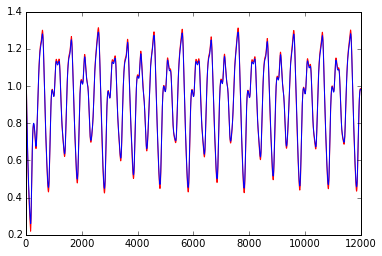

In [8]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

embedding_params = {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2,
                    'learning_rate': 0.01, 'loss': 'ls'}
train_params = {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 2,
                    'learning_rate': 0.01, 'loss': 'ls'}
clf_embed = ensemble.GradientBoostingRegressor(**embedding_params)
clf_train = ensemble.GradientBoostingRegressor(**train_params)

def train_model(X, delay, dim, clf):
    sample = embedding_reconstruction(X, delay=delay, dim=dim)
    
    train_vect = sample[:,0:3]
    output_vect = sample[:,-1]
    
    sample_size = len(output_vect)
    train_size = int(sample_size/2)

    train_X = train_vect[:train_size,]
    test_X = train_vect[train_size+1:,]

    train_Y = output_vect[:train_size]
    test_Y = output_vect[train_size+1:]
    
    clf.fit(train_X, train_Y)
    
    predict_Y = clf.predict(test_X)
    mse = mean_squared_error(test_Y, predict_Y)
    r2 = r2_score(test_Y, predict_Y)
    
    return {'model':clf, 'X':train_vect, 'Y': output_vect, 'predict_Y':clf.predict(train_vect) , 'mse':mse, 'r2':r2}

training_results = train_model(X,3,2, clf_train)
print(training_results['mse'],training_results['r2'])
plt.plot(training_results['Y'],'r-')
plt.plot(training_results['predict_Y'],'b-')

In [10]:
# Gradient Descent
def calculate_optimal_embedding(X, clf_to_use,  start_dim=5, start_delay=5):
    not_converged = True

    delay = start_delay
    dim = start_dim

    error_dict = dict()
    n_train = 0

    def calculate_fit_error(X, delay, dim, clf):
        global error_dict
        if (delay,dim) in error_dict:
            return error_dict[(delay,dim)]
        else:
            global n_train
            n_train += 1
            # print(" Training number: %s" % n_train)
            training_results = train_model(X, delay, dim, clf)
            error_dict[(delay,dim)] = training_results['mse']
            # print(error_dict)
            return error_dict[(delay, dim)]
    
    n_iter = 0
    while not_converged:
        prev_delay = delay
        prev_dim = dim
        n_iter += 1
        print(" Iteration number: %s" % n_iter)
        print("    Current Params: %s, %s" % (delay, dim))
        index_dict = dict()
        for i in range(3):
            for j in range(3):
                score= calculate_fit_error(X, delay+i-1, dim+j-1, clf_to_use)
                index_dict[score] = (i-1, j-1)
        min_val= min(index_dict.keys())
        d_delay, d_dim = index_dict[min_val]

        dim += d_dim
        delay += d_delay

        if prev_delay == delay and prev_dim == dim:
            not_converged = False
            break

        if delay == 1 and dim ==1:
            not_converged = False
            break
    return delay, dim

print('Delay: %s, Dim: %s' % calculate_optimal_embedding(X,clf_embed))

 Iteration number: 1
    Current Params: 5, 5
 Iteration number: 2
    Current Params: 4, 4
 Iteration number: 3
    Current Params: 4, 3
 Iteration number: 4
    Current Params: 3, 2
Delay: 3, Dim: 2


In [ ]:
delay = 6
dim = 1

embedding_m = embedding_reconstruction(X,delay,dim)
embedding_m_1 = embedding_reconstruction(X,delay, dim+1)

dist_m = make_sym_dist_matrix(embedding_m)
dist_m_1 = make_sym_dist_matrix(embedding_m_1)

In [ ]:
l = min([len(np.argmin(dist_m, axis=1)), len(np.argmin(dist_m_1, axis=1))])
sum((np.argmin(dist_m, axis=1)[:l] == np.argmin(dist_m_1, axis=1)[:l])*1)/l

In [ ]:
m = 25
y = X
RT = 15
AT= 2
sigmay = np.std(y)
nyr = len(y)

EM = embedding_reconstruction(y,6,m)

rEEM, cEEM =  EM.shape
embedm = 0
for k in range(2):
    fnn1 = []
    fnn2 = []

    D = make_sym_dist_matrix(EM[:,:k+1])
    print(D)
    for i in range(rEEM-m-k):
        if i -1 > 0:
            d11 = min(D[i,:i-1])
        else:
            d11 = 999999999999999.
        d12 = min(D[i,i+1:])
        Rm = min([d11, d12])
        l = np.where(D[i,:]==Rm)[0]
        if Rm > 0:
            if l+m+k-1 <= nyr:
                np.append(fnn1, abs(y[i+m+k-1] - y[l+m+k-1])/Rm)
                np.append(fnn2, abs(y[i+m+k-1] - y[l+m+k-1])/sigmay)
    
    fnn1 = np.array(fnn1)
    fnn2 = np.array(fnn2)
    
    Ind1 = np.where(fnn1>RT)
    Ind2 = np.where(fnn2 > AT)
    
    if len(Ind1) / len(fnn1) <0.1 and len(Ind2) / len(fnn1) < 0.1:
        embedm = k
        break
if embedm == 0: 
    embedm = cEEM

embedm

In [ ]:
D = make_sym_dist_matrix(EM[:,:5])

In [ ]:
D[5,:4]